# TS 2025 - Assignment 2

Before you begin, set the assignment seed to the student id of one of your team members in the cell below.
To choose the data for this set the assignment seed to the student id of one of the team members. The
cell is prefilled with an **example** student id, so make sure to change it and **run the cell** before proceeding
further.

In [2]:
# NB!: change this to the student id of one of your team members

assignment_seed = "7EB0100106"

## Presentation

Do not create powerpoint slides or similar presentations for this assignment. The only submission should be
this Jupyter notebook with the completed code and results.

For the presentation of your results please **only include**:

    - Plots
    - Numeric results
    - Tables of model parameters and summaries

**Do not include**:

    - Text in comments or markdown cells
    - Custom functions in the code
    - if-then-else statements or similar control flow structures
    - Loops (for, while, etc.)
    - Any other code that is not directly related to the assignment tasks
  
**Explanations**

For the presentation you should be able to explain all the steps and be able to answer questions about

- Why you use a specific model/test/plot
- What is shown in the plots and numeric results
- How to interpret the results
  
## Tasks

1. Run the following cell to load your data. It will be stored in the pandas Series `dt`. All time series
are stock prices from the SOFIX index. The data that you should use for the model selection is stored in the
series `train`. The data for testing the forecasts is stored in the series `test`.

2. Adjust the labels and titles of the plots to reflect the stock you are analyzing
3. Your task is to select an ARIMA model for the stock price.
   - Choose the order of differencing based on the ACF/PACF plots and unit root tests (ADF, KPSS)
   - Choose the AR and MA orders based on the ACF/PACF plots and information criteria (AIC, BIC)
4. After selecting the ARIMA model, analyze the residuals
   - Plot the residuals and their ACF/PACF
   - Perform the Ljung-Box test on the residuals
   - Plot the histogram and QQ-plot of the residuals
5. Analyze the volatility of the residuals using an appropriate plot
6. Fit several ARCH/GARCH models to the residuals
   - Plot the conditional volatility
   - Analyze the standardized residuals of the GARCH model (plots, Ljung-Box test, histogram, QQ-plot)
   - Test whether negative and positive shocks have different effects on volatility
  
7. Forecast the stock prices for the test period using the ARIMA model in two ways:
   - By manually differencing the data before fitting the ARIMA model
   - By using the integrated ARIMA model directly
   - Compare the forecasts from both methods and explain the differences, explain the meaning of an
     intercept in the ARIMA model with differenced data
   - Plot the forecasts along with the actual values
   - Compute the RMSE of the forecasts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 14.6 MB/s eta 0:00:00


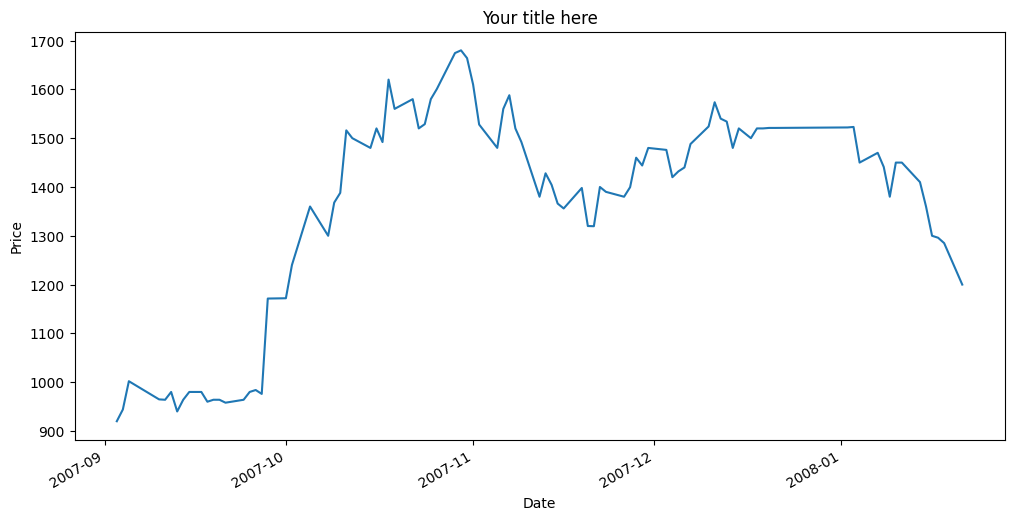

In [3]:
# Import libraries

%pip install arch

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from scipy import stats
import numpy as np

np.random.seed(int(re.sub(r"\D", "", assignment_seed)))

stocks = pd.read_excel("https://github.com/febse/data/raw/refs/heads/main/ts/SOFIX-Stocks.xlsx", usecols="A:Q").set_index("Date")

dt = stocks[np.random.choice(stocks.columns)]

# Split the data into training and test sets

train_size = int(len(dt) * 0.85)
train, test = dt[:train_size], dt[train_size:]

# Plot the training data

train.plot(title="Stock Price", figsize=(12, 6))

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Your title here")
plt.show()

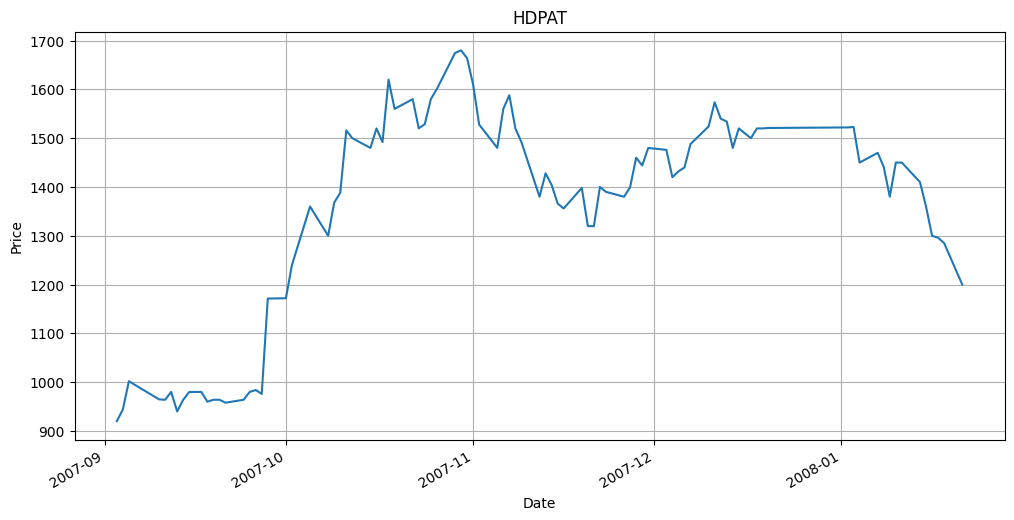

In [4]:
train.plot(figsize=(12,6))
plt.title(dt.name)
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()


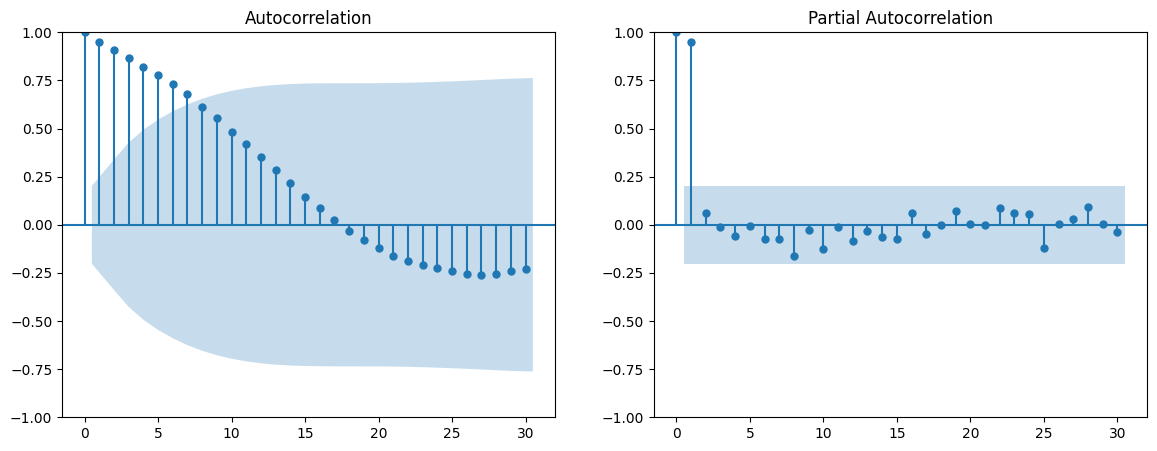

In [5]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
plot_acf(train, ax=ax[0], lags=30)
plot_pacf(train, ax=ax[1], lags=30)
plt.show()


In [22]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

adf_result = adfuller(train)

adf_table = pd.Series(
    adf_result[0:4],
    index=["Test Statistic", "p-value", "Lags Used", "Observations"]
)

for key, value in adf_result[4].items():
    adf_table[f"Critical Value ({key})"] = value

adf_table


,0
Test Statistic,-1.939065
p-value,0.313912
Lags Used,0.000000
Observations,93.000000
Critical Value (1%),-3.502705
Critical Value (5%),-2.893158
Critical Value (10%),-2.583637


In [23]:
from statsmodels.tsa.stattools import kpss

kpss_result = kpss(train, regression="c", nlags="auto")

kpss_table = pd.Series(
    kpss_result[0:3],
    index=["Test Statistic", "p-value", "Lags Used"]
)

for key, value in kpss_result[3].items():
    kpss_table[f"Critical Value ({key})"] = value

kpss_table

/tmp/ipython-input-1772100155.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(train, regression="c", nlags="auto")


,0
Test Statistic,0.780842
p-value,0.010000
Lags Used,5.000000
Critical Value (10%),0.347000
Critical Value (5%),0.463000
Critical Value (2.5%),0.574000
Critical Value (1%),0.739000


In [7]:
train_diff = train.diff().dropna()


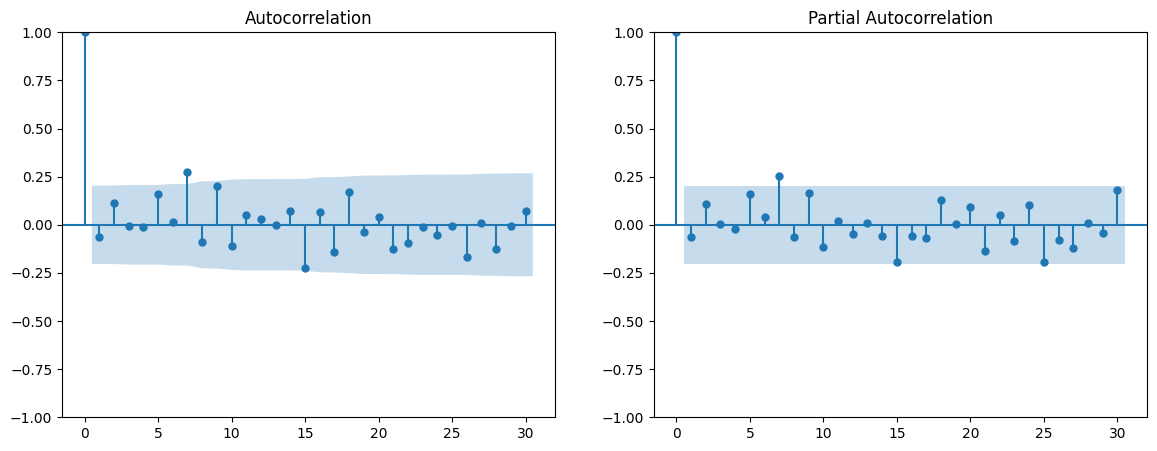

In [8]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
plot_acf(train_diff, ax=ax[0], lags=30)
plot_pacf(train_diff, ax=ax[1], lags=30)
plt.show()


In [24]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

adf_diff = adfuller(train_diff)

adf_diff_table = pd.Series(
    adf_diff[0:4],
    index=["Test Statistic", "p-value", "Lags Used", "Observations"]
)

for key, value in adf_diff[4].items():
    adf_diff_table[f"Critical Value ({key})"] = value

print("ADF Test (First Difference)")
display(adf_diff_table)



ADF Test (First Difference)


,0
Test Statistic,-9.970669e+00
p-value,2.244888e-17
Lags Used,0.000000e+00
Observations,9.200000e+01
Critical Value (1%),-3.503515e+00
Critical Value (5%),-2.893508e+00
Critical Value (10%),-2.583824e+00


In [25]:
from statsmodels.tsa.stattools import kpss

kpss_diff = kpss(train_diff, regression="c", nlags="auto")

kpss_diff_table = pd.Series(
    kpss_diff[0:3],
    index=["Test Statistic", "p-value", "Lags Used"]
)

for key, value in kpss_diff[3].items():
    kpss_diff_table[f"Critical Value ({key})"] = value

print("KPSS Test (First Difference)")
display(kpss_diff_table)


KPSS Test (First Difference)


,0
Test Statistic,0.553967
p-value,0.029512
Lags Used,2.000000
Critical Value (10%),0.347000
Critical Value (5%),0.463000
Critical Value (2.5%),0.574000
Critical Value (1%),0.739000


In [10]:
arima = ARIMA(train, order=(1,1,1))
arima_fit = arima.fit()
print(arima_fit.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  HDPAT   No. Observations:                   94
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -493.889
Date:                Tue, 13 Jan 2026   AIC                            993.778
Time:                        21:11:52   BIC                           1001.376
Sample:                             0   HQIC                           996.846
                                 - 94                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4714      0.951     -0.495      0.620      -2.336       1.393
ma.L1          0.3917      1.005      0.390      0.697      -1.579       2.362
sigma2      2400.0352    254.113      9.445      0.0

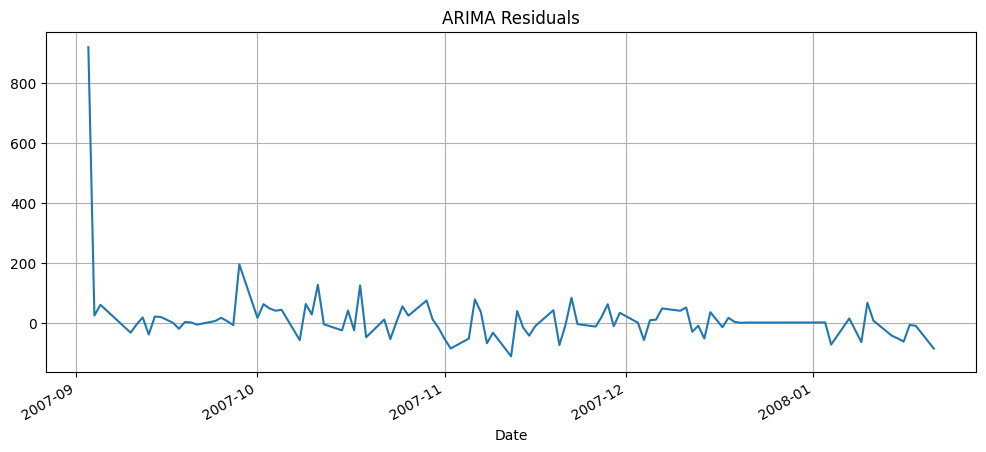

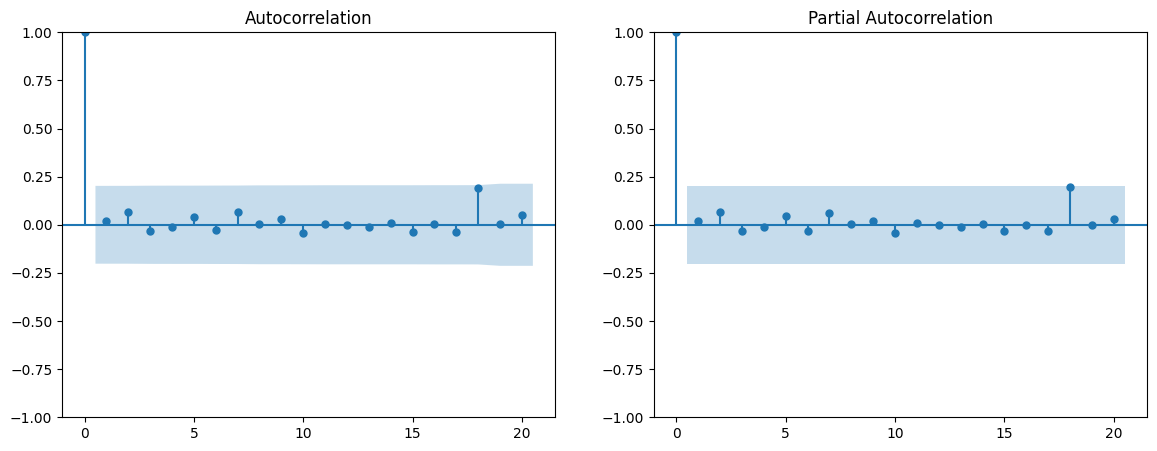

In [11]:
resid = arima_fit.resid

resid.plot(figsize=(12,5))
plt.title("ARIMA Residuals")
plt.grid(True)
plt.show()

fig, ax = plt.subplots(1,2, figsize=(14,5))
plot_acf(resid, ax=ax[0], lags=20)
plot_pacf(resid, ax=ax[1], lags=20)
plt.show()


In [12]:
from statsmodels.stats.diagnostic import acorr_ljungbox

print(acorr_ljungbox(resid, lags=[10,20], return_df=True))


     lb_stat  lb_pvalue
10  1.611752   0.998543
20  6.773491   0.997364


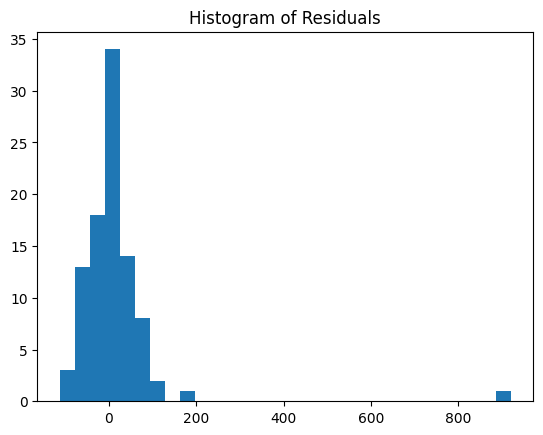

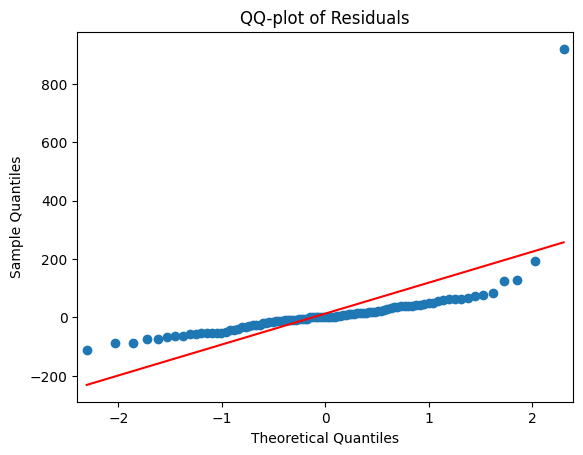

In [13]:
plt.hist(resid, bins=30)
plt.title("Histogram of Residuals")
plt.show()

from statsmodels.graphics.gofplots import qqplot
qqplot(resid, line='s')
plt.title("QQ-plot of Residuals")
plt.show()


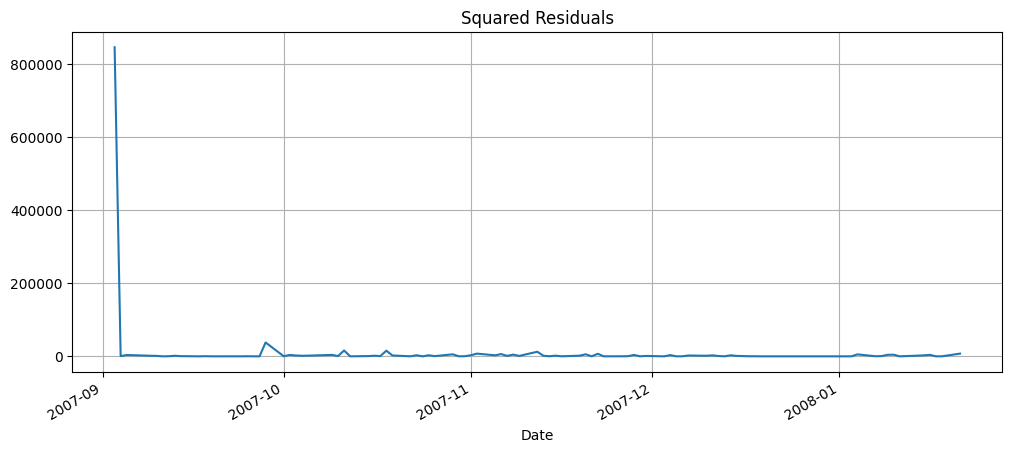

In [14]:
(resid**2).plot(figsize=(12,5))
plt.title("Squared Residuals")
plt.grid(True)
plt.show()


In [15]:
from arch import arch_model

scaled_resid = resid / 100

arch1 = arch_model(scaled_resid, vol='ARCH', p=1).fit(disp='off')
garch11 = arch_model(scaled_resid, vol='Garch', p=1, q=1).fit(disp='off')
gjr = arch_model(scaled_resid, vol='Garch', p=1, o=1, q=1).fit(disp='off')

print(arch1.summary())
print(garch11.summary())
print(gjr.summary())


                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -87.3968
Distribution:                  Normal   AIC:                           180.794
Method:            Maximum Likelihood   BIC:                           188.423
                                        No. Observations:                   94
Date:                Tue, Jan 13 2026   Df Residuals:                       93
Time:                        21:11:54   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0775  6.829e-02      1.135      0.257 [-5.63

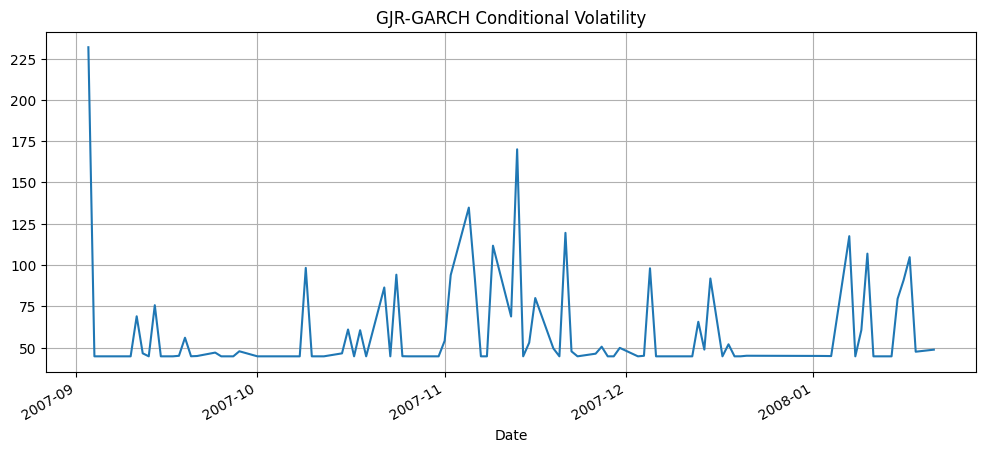

In [16]:
(gjr.conditional_volatility * 100).plot(figsize=(12,5))
plt.title("GJR-GARCH Conditional Volatility")
plt.grid(True)
plt.show()


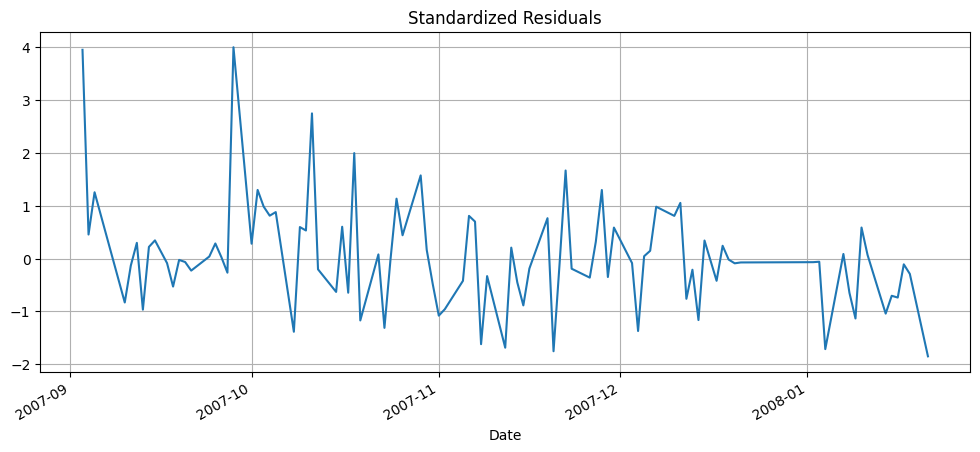

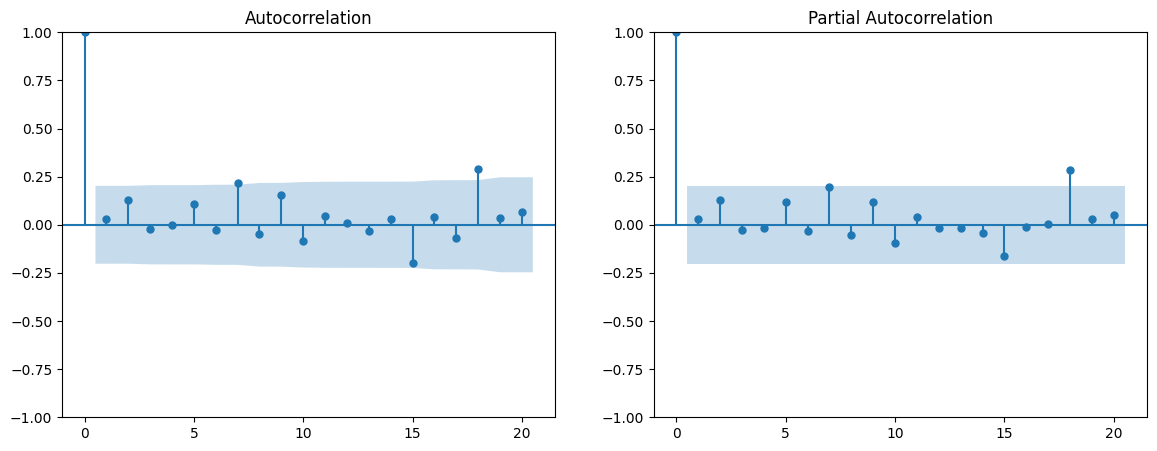

      lb_stat  lb_pvalue
10  11.466804   0.322324
20  27.767224   0.115025


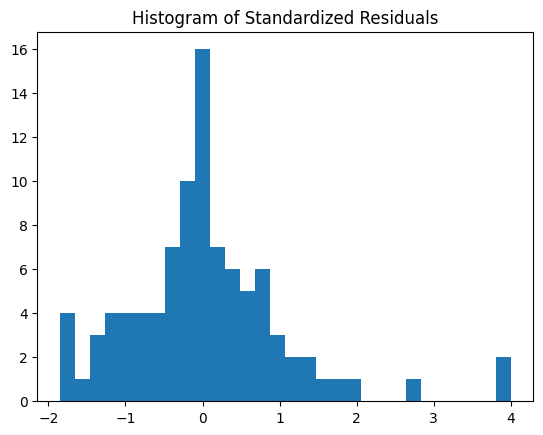

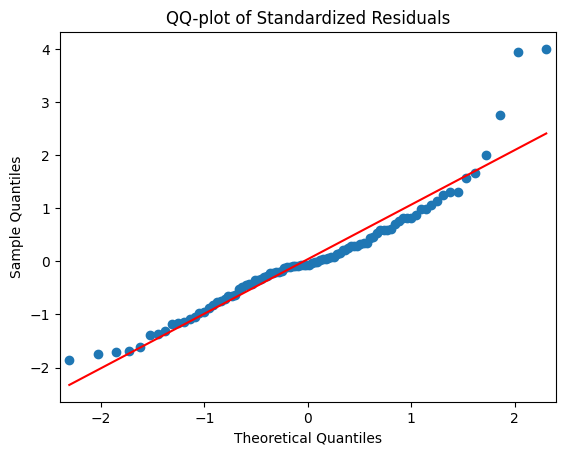

In [17]:
std_resid = gjr.std_resid

std_resid.plot(figsize=(12,5))
plt.title("Standardized Residuals")
plt.grid(True)
plt.show()

fig, ax = plt.subplots(1,2, figsize=(14,5))
plot_acf(std_resid, ax=ax[0], lags=20)
plot_pacf(std_resid, ax=ax[1], lags=20)
plt.show()

print(acorr_ljungbox(std_resid, lags=[10,20], return_df=True))

plt.hist(std_resid, bins=30)
plt.title("Histogram of Standardized Residuals")
plt.show()

qqplot(std_resid, line='s')
plt.title("QQ-plot of Standardized Residuals")
plt.show()


In [18]:
train_diff_manual = train.diff().dropna()

arima_manual = ARIMA(train_diff_manual, order=(1,0,1)).fit()
print(arima_manual.summary())

diff_forecast = arima_manual.forecast(steps=len(test))
forecast_manual = train.iloc[-1] + diff_forecast.cumsum()
forecast_manual.index = test.index


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  HDPAT   No. Observations:                   93
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -493.686
Date:                Tue, 13 Jan 2026   AIC                            995.371
Time:                        21:11:59   BIC                           1005.502
Sample:                             0   HQIC                           999.462
                                 - 93                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0429      5.197      0.586      0.558      -7.143      13.229
ar.L1         -0.4677      0.923     -0.507      0.612      -2.276       1.341
ma.L1          0.3847      0.975      0.394      0.6

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [19]:
forecast_integrated = arima_fit.forecast(steps=len(test))
forecast_integrated.index = test.index


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


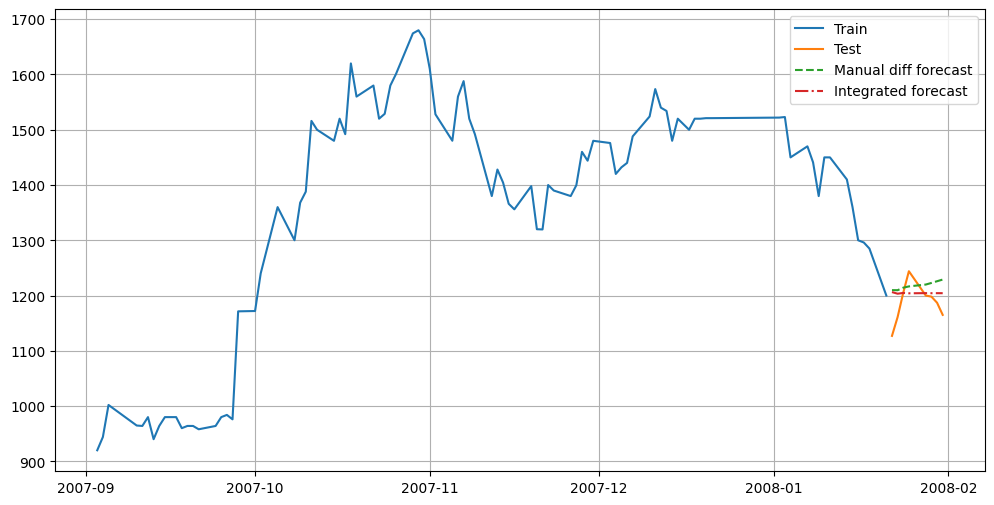

In [20]:
plt.figure(figsize=(12,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(forecast_manual, '--', label="Manual diff forecast")
plt.plot(forecast_integrated, '-.', label="Integrated forecast")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
from sklearn.metrics import mean_squared_error
test_clean = test.dropna()

forecast_manual_clean = forecast_manual.loc[test_clean.index]
forecast_integrated_clean = forecast_integrated.loc[test_clean.index]

rmse_manual = np.sqrt(mean_squared_error(test_clean, forecast_manual_clean))
rmse_integrated = np.sqrt(mean_squared_error(test_clean, forecast_integrated_clean))

print("RMSE Manual Diff:", rmse_manual)
print("RMSE Integrated:", rmse_integrated)




RMSE Manual Diff: 45.64517772407876
RMSE Integrated: 38.024118822210724
